In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('data/tweets.csv', usecols=['Text','Vader_Sentiment_Type'])

In [3]:
df.dropna(inplace=True)

In [4]:
df = df.drop_duplicates(subset=['Text'])

In [5]:
df.shape

(19775, 2)

In [6]:
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("emoji", first=True)
nlp.pipe_names

['emoji',
 'tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner']

In [7]:
from tqdm import tqdm

docs = []
for doc in tqdm(nlp.pipe(df.Text), total=len(df)):
    docs.append(doc)

100%|██████████| 19775/19775 [01:24<00:00, 233.79it/s]


In [8]:
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_, i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct, i._.is_emoji) for i in doc
    ]

In [9]:
def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct", "is_emoji"
    ]
    
    meta_df = []
    for ix, doc in tqdm(enumerate(docs), total=len(docs)):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df)  

In [10]:
tidy_docs = tidy_tokens(docs)

100%|██████████| 19775/19775 [00:39<00:00, 501.04it/s]


In [11]:
tidy_docs.query("is_emoji == True")

,doc_id,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct,is_emoji
29,5,™,29,™,,NNPS,npadvmod,PROPN,False,False,False,False,True
37,16,🙄,37,🙄,,NN,dobj,NOUN,False,False,False,False,True
16,19,✅,16,✅,,_SP,dep,SPACE,False,False,False,False,True
0,30,💗,0,💗,,NNP,dep,PROPN,False,False,False,False,True
38,50,😢,38,😢,,ADD,ROOT,X,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,19758,🏳️‍🌈,51,🏳️‍🌈,ORG,ADD,dep,X,False,False,False,False,True
52,19758,🏳️‍🌈,52,🏳️‍🌈,ORG,ADD,dep,X,False,False,False,False,True
53,19758,🏳️‍🌈,53,🏳️‍🌈,ORG,VBP,nmod,VERB,False,False,False,False,True
23,19769,🌈,23,🌈,,NN,npadvmod,NOUN,False,False,False,False,True


In [12]:
tidy_docs.query("ent_type != ''").ent_type.value_counts()

ORG            21462
PERSON         16156
MONEY          13066
GPE             5187
DATE            4811
NORP            4344
CARDINAL        3736
WORK_OF_ART     1685
PRODUCT         1007
PERCENT          823
TIME             679
LAW              569
LOC              568
ORDINAL          501
FAC              448
EVENT            381
QUANTITY         124
LANGUAGE          35
Name: ent_type, dtype: int64

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 [Text(0.0, 0, '0'),
  Text(2000.0, 0, '2000'),
  Text(4000.0, 0, '4000'),
  Text(6000.0, 0, '6000'),
  Text(8000.0, 0, '8000'),
  Text(10000.0, 0, '10000')])

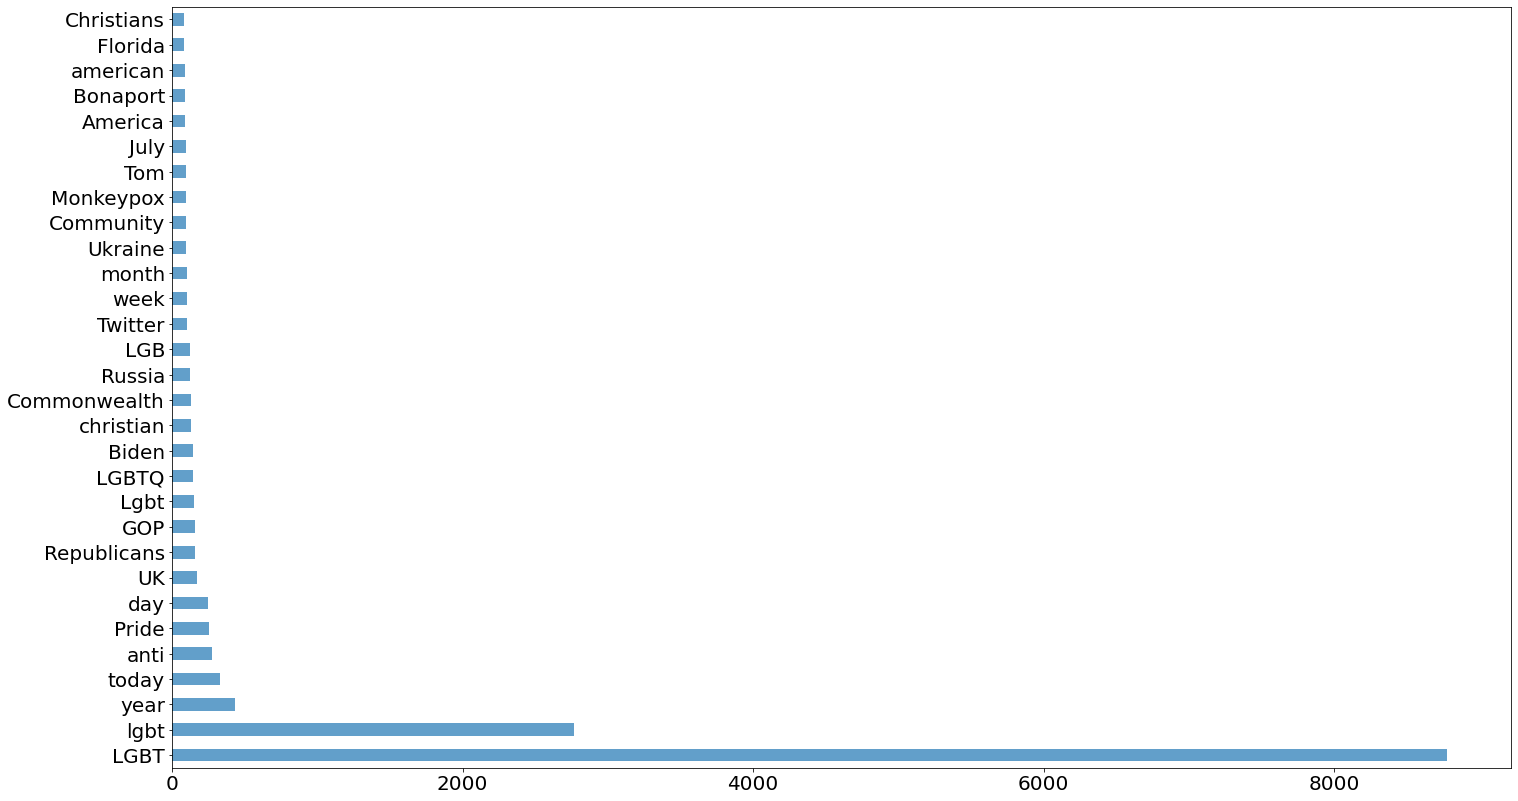

In [13]:
import matplotlib.pyplot as plt 

tidy_docs.query("ent_type != '' & pos != 'SPACE' & is_stop == False & \
is_punct == False & is_emoji == False & is_digit == False & is_alpha == True").lemma.value_counts().head(30).plot(kind="barh", figsize=(24, 14), alpha=.7)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)